In [1]:
import os
import glob
import torch
import cv2
from PIL import Image
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm as tqdm
import json
import seaborn as sns

In [2]:
df = pd.read_csv('../data/frame_diff.csv')
df['first_person_label'] = np.nan
df['second_person_label'] = np.nan
df['first_person_frame_labels'] = np.nan
df['second_person_frame_labels'] = np.nan
df['first_person_frame_labels'] = df['first_person_frame_labels'].astype('object')
df['second_person_frame_labels'] = df['second_person_frame_labels'].astype('object')
df.head()

,index,original,first_person_similarities,second_person_similarities,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels
0,gmuagvvcen.mp4,xyioxposka.mp4,[0.90662205 0.91454544 0.90863778 0.90787758 0...,NaN,NaN,NaN,NaN,NaN
1,nlbejgudfx.mp4,acguxjvmju.mp4,[0.87670463 0.87884638 0.88174117 0.88052886 0...,NaN,NaN,NaN,NaN,NaN
2,smptxlklxc.mp4,NaN,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,NaN,NaN,NaN,NaN,NaN
3,xmodyeeaxr.mp4,ptpwappdyx.mp4,[0.96768544 0.9703409 0.96584001 0.96793804 0...,NaN,NaN,NaN,NaN,NaN
4,hvxrsfgvyi.mp4,qelncdmypn.mp4,[0.93245532 0.93241838 0.93094194 0.93391931 0...,[0.96927007 0.9687523 0.97080696 0.96831491 0...,NaN,NaN,NaN,NaN


In [53]:
def classifyFrame(similarity, SIMILARITY_TH):
    if similarity > SIMILARITY_TH:
        return 0
    elif similarity > 0.95:
        return 1
    elif similarity > 0.9:
        return 2
    elif similarity > 0.85:
        return 3
    else:
        return 4
    
def str2array(text):
    if type(text)==float:
        return None
    values = text.replace('\n','').replace('[','').replace(']','').split(' ')
    values = [val for val in values if val != ""]
    return np.array(values, np.float32)

def arrayMean(arr):
    if arr is None:
        return None
    return np.mean(arr)

def arrayMin(arr):
    if arr is None:
        return None
    return min(arr)

def arrayMax(arr):
    if arr is None:
        return None
    return max(arr)

def arrayStd(arr):
    if arr is None:
        return None
    return np.std(arr)

Read frame similarity dataframe

In [5]:
df_diff = pd.read_csv('../data/frame_diff.csv')
df_diff = df_diff[~df_diff['original'].isnull()]
df_diff.head()

,index,original,first_person_similarities,second_person_similarities
0,gmuagvvcen.mp4,xyioxposka.mp4,[0.90662205 0.91454544 0.90863778 0.90787758 0...,NaN
1,nlbejgudfx.mp4,acguxjvmju.mp4,[0.87670463 0.87884638 0.88174117 0.88052886 0...,NaN
3,xmodyeeaxr.mp4,ptpwappdyx.mp4,[0.96768544 0.9703409 0.96584001 0.96793804 0...,NaN
4,hvxrsfgvyi.mp4,qelncdmypn.mp4,[0.93245532 0.93241838 0.93094194 0.93391931 0...,[0.96927007 0.9687523 0.97080696 0.96831491 0...
5,duhilxsfwa.mp4,pfbdxvexft.mp4,[0.89427626 0.90188644 0.89832524 0.9075775 0...,NaN


In [6]:
# first person
df_diff['avg_first_person_similarity'] = [arrayMean(str2array(df_diff.loc[i,'first_person_similarities'])) for i in df_diff.index.values]
df_diff['min_first_person_similarity'] = [arrayMin(str2array(df_diff.loc[i,'first_person_similarities'])) for i in df_diff.index.values]
df_diff['max_first_person_similarity'] = [arrayMax(str2array(df_diff.loc[i,'first_person_similarities'])) for i in df_diff.index.values]
df_diff['std_first_person_similarity'] = [arrayStd(str2array(df_diff.loc[i,'first_person_similarities'])) for i in df_diff.index.values]

# second person
df_diff['avg_second_person_similarity'] = [arrayMean(str2array(df_diff.loc[i,'second_person_similarities'])) for i in df_diff.index.values]
df_diff['min_second_person_similarity'] = [arrayMin(str2array(df_diff.loc[i,'second_person_similarities'])) for i in df_diff.index.values]
df_diff['max_second_person_similarity'] = [arrayMax(str2array(df_diff.loc[i,'second_person_similarities'])) for i in df_diff.index.values]
df_diff['std_second_person_similarity'] = [arrayStd(str2array(df_diff.loc[i,'second_person_similarities'])) for i in df_diff.index.values]

If we make the assumption, that on at least some of the two-person fake videos, one person is real. Then, when comparing the two-person similarities, real one is close to 1.0 and the fake one lower. The minimum similarity comparison is perhaps the most reliable measure because in a sequence of frames, only a few of them can be altered faces.

Text(0.5, 0.98, 'Real person > 0.96')

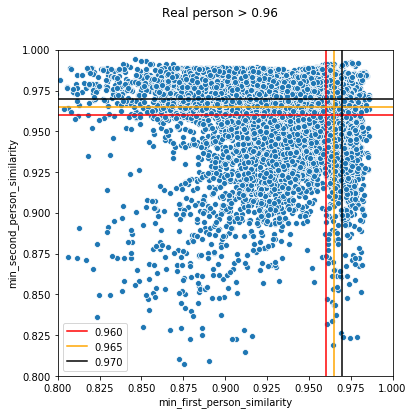

In [25]:
import matplotlib.lines as mlines

SIMILARITY_TH_1 = 0.96
SIMILARITY_TH_2 = 0.965
SIMILARITY_TH_3 = 0.97

f,ax = plt.subplots(1,1,figsize=(6,6))
sns.scatterplot(x='min_first_person_similarity',y='min_second_person_similarity',data=df_diff, ax=ax)

l = mlines.Line2D([0,1], [SIMILARITY_TH_1,SIMILARITY_TH_1], color='r')
l2 = mlines.Line2D([SIMILARITY_TH_1,SIMILARITY_TH_1],[0,1],color='r',label='{0:.3f}'.format(SIMILARITY_TH_1))
ax.add_line(l)
ax.add_line(l2)

l3 = mlines.Line2D([0,1], [SIMILARITY_TH_2,SIMILARITY_TH_2], color='orange')
l4 = mlines.Line2D([SIMILARITY_TH_2,SIMILARITY_TH_2],[0,1],color='orange',label='{0:.3f}'.format(SIMILARITY_TH_2))
ax.add_line(l3)
ax.add_line(l4)

l5 = mlines.Line2D([0,1], [SIMILARITY_TH_3,SIMILARITY_TH_3], color='black')
l6 = mlines.Line2D([SIMILARITY_TH_3,SIMILARITY_TH_3],[0,1],color='black',label='{0:.3f}'.format(SIMILARITY_TH_3))
ax.add_line(l5)
ax.add_line(l6)


ax.set_xlim(0.8,1)
ax.set_ylim(0.8,1)
ax.legend()
f.suptitle('Real person > {0}'.format(SIMILARITY_TH))

Now, examine one person cases and see what are the minimum similarities. These should be all from altered faces.

In [12]:
df_diff_one_person = df_diff[df_diff['second_person_similarities'].isnull()]

In [16]:
df_diff_one_person['min_first_person_similarity'].describe()

count    87939.000000
mean         0.914176
std          0.043572
min          0.155801
25%          0.895600
50%          0.920969
75%          0.941949
max          0.985610
Name: min_first_person_similarity, dtype: float64

Fake frame similarities can go as high as 0.9856.

In [19]:
for perc in range(75,100):
    print('percentile {0}, similarity {1:.3f}'.format(perc,
                                                      np.percentile(df_diff_one_person['min_first_person_similarity'].dropna().values, perc)))

percentile 75, similarity 0.942
percentile 76, similarity 0.943
percentile 77, similarity 0.944
percentile 78, similarity 0.945
percentile 79, similarity 0.946
percentile 80, similarity 0.946
percentile 81, similarity 0.947
percentile 82, similarity 0.948
percentile 83, similarity 0.950
percentile 84, similarity 0.951
percentile 85, similarity 0.952
percentile 86, similarity 0.953
percentile 87, similarity 0.954
percentile 88, similarity 0.955
percentile 89, similarity 0.957
percentile 90, similarity 0.958
percentile 91, similarity 0.959
percentile 92, similarity 0.961
percentile 93, similarity 0.962
percentile 94, similarity 0.964
percentile 95, similarity 0.965
percentile 96, similarity 0.967
percentile 97, similarity 0.969
percentile 98, similarity 0.972
percentile 99, similarity 0.976


- Having a threshold of 0.960 would remove 8-9 percent of the assumed altered videofakes.
- Having a threshold of 0.965 would remove 5 percent of the assumed altered videofakes.
- Having a threshold of 0.97 would remove 2 percent of the assumed altered videofakes.

Assuming that in two person videos, the other one is only a fake. Then, we can take the max out of person minimum frame similarities and assume that is always from genuine frames. 

In [26]:
df_diff_two_person = df_diff[~df_diff['second_person_similarities'].isnull()]

In [38]:
df_diff_two_person['max_persons_min_frame_similarity'] = np.max(np.concatenate([np.expand_dims(df_diff_two_person['min_first_person_similarity'].values,axis=0),
       np.expand_dims(df_diff_two_person['min_second_person_similarity'].values,axis=0)]),0)

/home/joni/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [49]:
for perc in range(0,100):
    print('percentile {0}, similarity {1:.3f}'.format(perc,
                                                      np.percentile(df_diff_two_person['max_persons_min_frame_similarity'].dropna().values, perc)))

percentile 0, similarity 0.609
percentile 1, similarity 0.872
percentile 2, similarity 0.897
percentile 3, similarity 0.911
percentile 4, similarity 0.920
percentile 5, similarity 0.926
percentile 6, similarity 0.931
percentile 7, similarity 0.934
percentile 8, similarity 0.938
percentile 9, similarity 0.941
percentile 10, similarity 0.943
percentile 11, similarity 0.945
percentile 12, similarity 0.946
percentile 13, similarity 0.948
percentile 14, similarity 0.950
percentile 15, similarity 0.951
percentile 16, similarity 0.952
percentile 17, similarity 0.953
percentile 18, similarity 0.954
percentile 19, similarity 0.955
percentile 20, similarity 0.956
percentile 21, similarity 0.957
percentile 22, similarity 0.958
percentile 23, similarity 0.959
percentile 24, similarity 0.959
percentile 25, similarity 0.960
percentile 26, similarity 0.961
percentile 27, similarity 0.961
percentile 28, similarity 0.962
percentile 29, similarity 0.963
percentile 30, similarity 0.963
percentile 31, sim

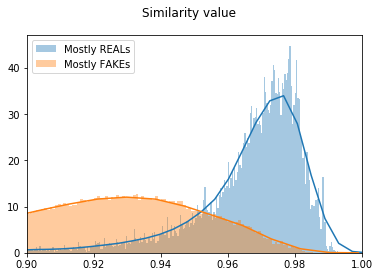

In [48]:
n_bins=1000
sns.distplot(df_diff_two_person['max_persons_min_frame_similarity'].dropna(),bins=n_bins, label='Mostly REALs')
sns.distplot(df_diff_one_person['min_first_person_similarity'].dropna(), bins=n_bins,label='Mostly FAKEs')
#sns.distplot(df_diff['std_second_person_similarity'], label='std')
plt.xlabel('')
plt.suptitle('Similarity value')
plt.xlim(0.90,1)
plt.legend()

The fakes with a high similarity value are most likey facial reenactments with only a small altered area. We would like to preserve many hard FAKE samples but also, filter out as many of the unaltered images, labeled as fakes. 

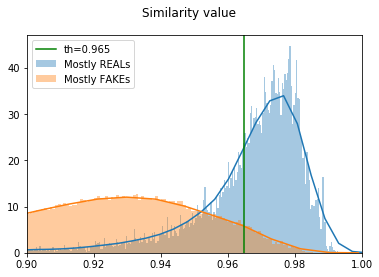

In [52]:
n_bins=1000
f,ax = plt.subplots(1,1,figsize=(6,4))

sns.distplot(df_diff_two_person['max_persons_min_frame_similarity'].dropna(),bins=n_bins, label='Mostly REALs',ax=ax)
sns.distplot(df_diff_one_person['min_first_person_similarity'].dropna(), bins=n_bins,label='Mostly FAKEs',ax=ax)

l = mlines.Line2D([SIMILARITY_TH_2,SIMILARITY_TH_2],[0,100],color='green',label='th={0:.3f}'.format(SIMILARITY_TH_2))
ax.add_line(l)

#sns.distplot(df_diff['std_second_person_similarity'], label='std')
ax.set_xlabel('')
f.suptitle('Similarity value')
ax.set_xlim(0.90,1)
ax.legend()

Threshold of 0.965 removes 2/3 of REALs and keeps 95% of FAKEs.

In [54]:
for ind in tqdm(df.index.values):
    firstPersonArr = str2array(df.loc[ind,'first_person_similarities'])
    secondPersonArr = str2array(df.loc[ind,'second_person_similarities'])
    firstClasses = [classifyFrame(val,SIMILARITY_TH_2) for val in firstPersonArr] if firstPersonArr is not None else np.nan 
    secondClasses = [classifyFrame(val,SIMILARITY_TH_2) for val in secondPersonArr] if secondPersonArr is not None else np.nan
    firstClass = max(firstClasses) if firstClasses is not np.nan else np.nan
    secondClass = max(secondClasses) if secondClasses is not np.nan else np.nan
    df.at[ind,'first_person_label'] = firstClass
    df.at[ind,'second_person_label'] = secondClass
    df.at[ind,'first_person_frame_labels'] = firstClasses
    df.at[ind,'second_person_frame_labels'] = secondClasses

In [55]:
df.head()

,index,original,first_person_similarities,second_person_similarities,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels
0,gmuagvvcen.mp4,xyioxposka.mp4,[0.90662205 0.91454544 0.90863778 0.90787758 0...,NaN,3.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, ...",NaN
1,nlbejgudfx.mp4,acguxjvmju.mp4,[0.87670463 0.87884638 0.88174117 0.88052886 0...,NaN,3.0,NaN,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",NaN
2,smptxlklxc.mp4,NaN,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,NaN,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN
3,xmodyeeaxr.mp4,ptpwappdyx.mp4,[0.96768544 0.9703409 0.96584001 0.96793804 0...,NaN,1.0,NaN,"[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, ...",NaN
4,hvxrsfgvyi.mp4,qelncdmypn.mp4,[0.93245532 0.93241838 0.93094194 0.93391931 0...,[0.96927007 0.9687523 0.97080696 0.96831491 0...,2.0,0.0,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


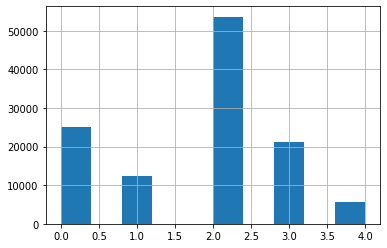

In [56]:
df.first_person_label.hist()

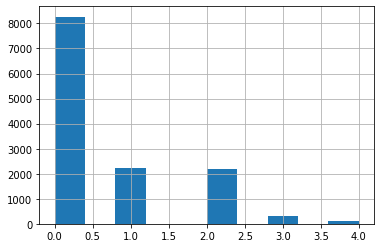

In [57]:
df.second_person_label.hist()

In [58]:
df_splits = pd.read_csv('../data/metadata_tr_val_split_folds.csv')
df_splits.head()

,index,label,split,isVal,cv_fold,person_count,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels,original,version
0,gmuagvvcen.mp4,FAKE,1st_level,False,3,1,3.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, ...",NaN,xyioxposka.mp4,2020-02-17
1,nlbejgudfx.mp4,FAKE,1st_level,False,1,1,3.0,NaN,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",NaN,acguxjvmju.mp4,2020-02-17
2,smptxlklxc.mp4,REAL,1st_level,False,0,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
3,xmodyeeaxr.mp4,FAKE,1st_level,False,1,1,1.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...",NaN,ptpwappdyx.mp4,2020-02-17
4,hvxrsfgvyi.mp4,FAKE,1st_level,False,2,2,2.0,0.0,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",qelncdmypn.mp4,2020-02-17


In [59]:
df_splits['first_person_frame_labels'] = df['first_person_frame_labels'].values
df_splits['second_person_frame_labels'] = df['second_person_frame_labels'].values
df_splits['first_person_label'] = df['first_person_label'].values
df_splits['second_person_label'] = df['second_person_label'].values
df_splits.head()

,index,label,split,isVal,cv_fold,person_count,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels,original,version
0,gmuagvvcen.mp4,FAKE,1st_level,False,3,1,3.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, ...",NaN,xyioxposka.mp4,2020-02-17
1,nlbejgudfx.mp4,FAKE,1st_level,False,1,1,3.0,NaN,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",NaN,acguxjvmju.mp4,2020-02-17
2,smptxlklxc.mp4,REAL,1st_level,False,0,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
3,xmodyeeaxr.mp4,FAKE,1st_level,False,1,1,1.0,NaN,"[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, ...",NaN,ptpwappdyx.mp4,2020-02-17
4,hvxrsfgvyi.mp4,FAKE,1st_level,False,2,2,2.0,0.0,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",qelncdmypn.mp4,2020-02-17


In [60]:
# replace
df_splits.to_csv('../data/metadata_tr_val_split_folds.csv', index=False)